<a href="https://colab.research.google.com/github/lsolomyak/AutoEncoderImageDenoise/blob/master/seismic_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising pipeline

In [ ]:
!nvidia-smi

Mon Aug 21 09:21:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Shape: (501, 3000)


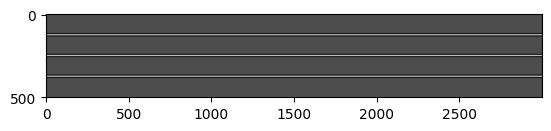

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file
eg_file = np.load('/content/drive/MyDrive/Team CGG/Data/synth_data/npy_input/train/synth_clean/image_0.npy')

# Print the shape
print("Shape:", eg_file.shape)

# Visualize the data (if it's 2D)
if eg_file.ndim == 2:
    plt.imshow(eg_file, cmap='gray')
    plt.show()

### Introduction

>**note** we assume you have run through segy_import_npy_output and have the necessary npy files loaded and ready to go

In seismic data, a trace represents the recorded seismic energy as it travels through the Earth and is detected by a receiver. It's a continuous time series of amplitude values that reflect the subsurface geological structure. In the given code, the trace data is extracted from a SEGY file, which is a standard format for storing seismic data, and then plotted to visualize the waveform. This can provide insights into the properties and composition of underground layers, such as rock formations and potential hydrocarbon reservoirs.



the code has read a single 2D slice from the 3D SEGY file, corresponding to a specific inline. This 2D slice can be thought of as an "image" of the subsurface along that inline, with the horizontal axis representing crosslines and the vertical axis representing time or depth.

In [2]:
import sys
sys.path.append('../scripts')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import reduce_mean
from tensorflow.image import ssim
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow as tf
import random
import gc
#from patchify import patchify, unpatchify

The problem we have here is that our images are 501 x 3000 which are terrible numbers to work with- so we pad it by 504 before resizing for windows of 32x70-(those windows are arbitrary but hopefully allow for a kernel of 6x7)

- **resize Function:**
  
  - **not** to be confused with padding the window- here we are just turning the images into larges pictures so that they are more easily divisble into 512x512 windows
  - This function pads an image to make its dimensions divisible by the window size.
  - Padding is added at the bottom and right edges of the image.

note- we save it as float32 which is easier for the cpu

- **Image to Windows Conversion Function:**
  - This function takes an image and divides it into non-overlapping windows of size \( h \times w \).*italicized text*
  - It uses the `pad_image` function to ensure that the dimensions are divisible by the window size.


In [3]:
def resize_image(image):
    #Good thing for us to check that  the original image is of shape (501, 3000)
    assert image.shape == (501, 3000), "Input image shape must be (501, 3000)"
    x_addition = np.zeros((11, 3000))
    y_addition = np.zeros((512, 72))
    image = np.concatenate((image, x_addition), axis=0)
    image = np.concatenate((image, y_addition), axis=1)

    return image


def img2windows(image, h, w):
    cropped_image = resize_image(image)
    return [cropped_image[i:i+h, j:j+w] for i in range(0, cropped_image.shape[0], h) for j in range(0, cropped_image.shape[1], w)]


- **Data Generator Function:**
  - This function generates batches of clean and noisy window pairs from the given folder path.

> please not the *modification* now the batch size will determine how many windows are passed not how many full images are passed down

Now if you want to test your script- rather than running it on all the data (it takes a long time) you can hold out and only train it on the number of slices you want



In [4]:
def data_generator(folder_path, h, w, batch_size, full_train=True):
    clean_folder = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if 'clean' in f][0]
    noisy_folder = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if 'noisy' in f][0]
    clean_file_names = [f for f in os.listdir(clean_folder) if f.endswith('.npy')]

    # If not full_train, select only 8 random files
    if not full_train:
        clean_file_names = random.sample(clean_file_names, 4)

    print(len(clean_file_names))
    random.seed(42)
    random.shuffle(clean_file_names)

    while True:
        all_clean_windows = []
        all_noisy_windows = []

        for clean_file in clean_file_names:
            clean_image = np.load(os.path.join(clean_folder, clean_file)).astype(np.float32)
            noisy_image = np.load(os.path.join(noisy_folder, clean_file)).astype(np.float32)

            all_clean_windows.extend(img2windows(clean_image, h, w))
            all_noisy_windows.extend(img2windows(noisy_image, h, w))
        for start_idx in range(0, len(all_clean_windows), batch_size):
            end_idx = min(start_idx + batch_size, len(all_clean_windows))
            clean_windows = np.array(all_clean_windows[start_idx:end_idx])
            noisy_windows = np.array(all_noisy_windows[start_idx:end_idx])
            yield (clean_windows, noisy_windows)

        # Force garbage collection
        gc.collect()







### visualizing the windows

its quite nice to see side by side how the noisy and clean images look

/content
4
(384, 64, 64)


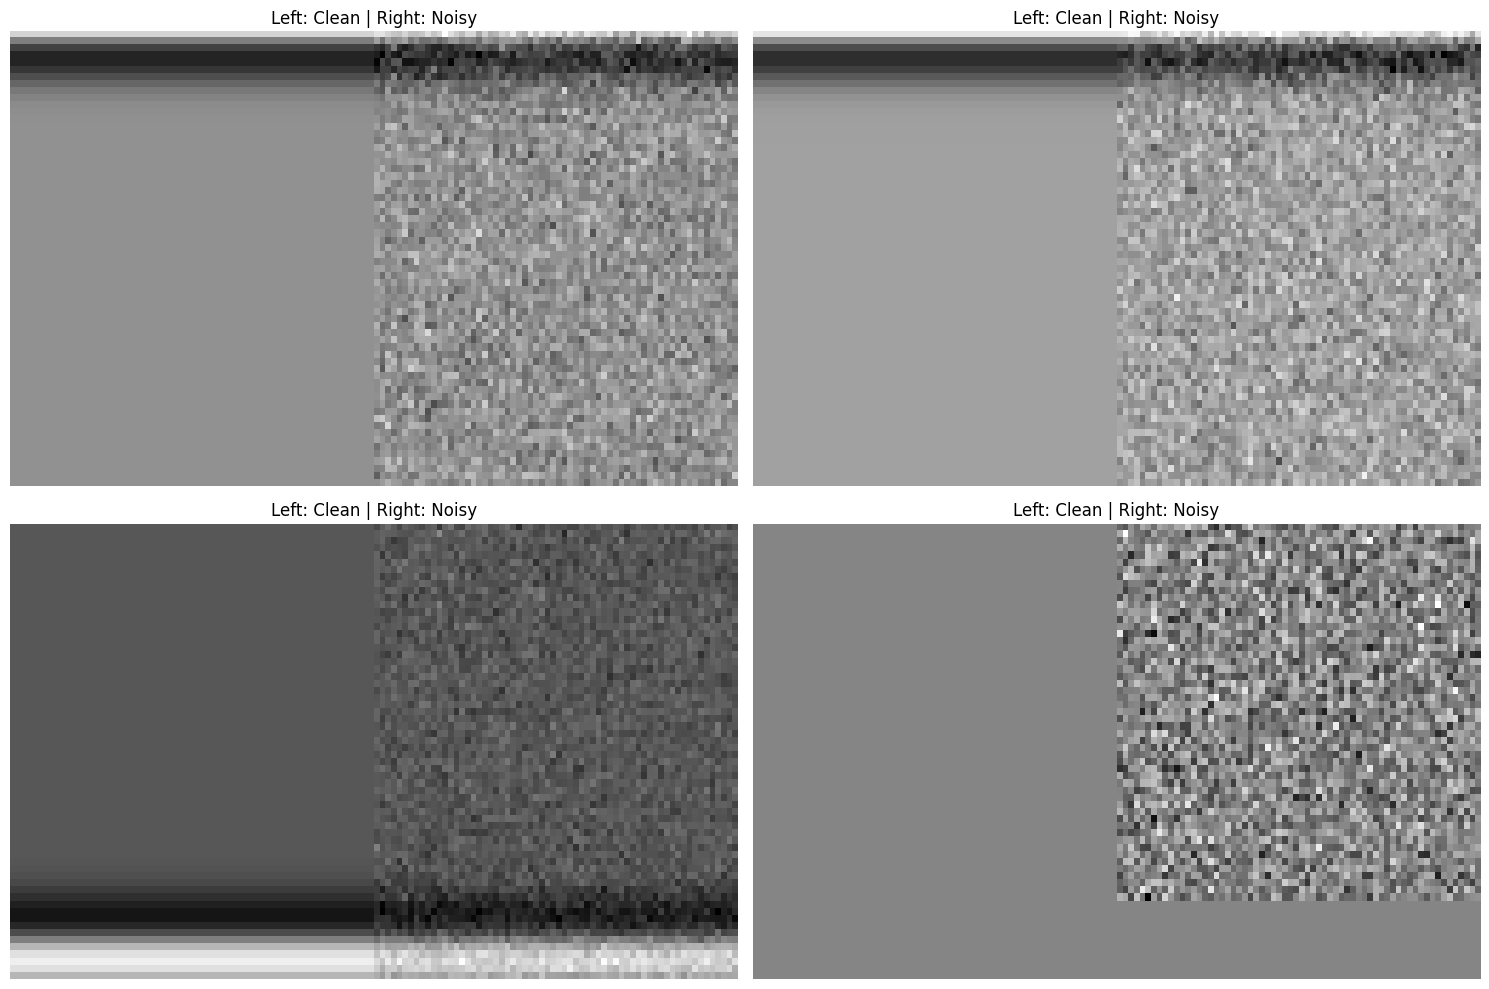

In [5]:
import os


def visualize_windows(clean_windows, noisy_windows, num_rows=2, num_cols=2):
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for row in range(num_rows):
        for col in range(num_cols):
            idx = random.randint(0, len(clean_windows) - 1)
            clean_window = clean_windows[idx]
            noisy_window = noisy_windows[idx]

            axs[row, col].imshow(np.hstack((clean_window, noisy_window)), cmap='gray', aspect='auto')
            axs[row, col].set_title('Left: Clean | Right: Noisy')
            axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()
print(os.getcwd())
h = 64
w = 64
# 384 is one full image so use multiples of this number
batch_size = 384
folder_path_train = '/content/drive/MyDrive/Team CGG/Data/synth_data/npy_input/train'
folder_path_test =  '/content/drive/MyDrive/Team CGG/Data/synth_data/npy_input/test'

train_generator = data_generator(folder_path_train, h, w, batch_size,full_train=False)
test_generator = data_generator(folder_path_test, h, w, batch_size,full_train=False)

clean_batch_train, noisy_batch_train = next(train_generator)

print(clean_batch_train.shape)

visualize_windows(clean_batch_train, noisy_batch_train)


### Choosing an autoencoder model

In [ ]:
# Importing necessary libraries
from tensorflow.keras import layers, models

def simple_autoencoder(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoding Path
    x = layers.Conv2D(16, (3, 3), activation='elu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='elu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoding Path
    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)

    # Output layer with the original shape
    outputs = layers.Conv2D(input_shape[-1], (3, 3), activation=None, padding='same')(x)

    return models.Model(inputs, outputs)

input_shape = (64, 64, 1)
simple_autoencoder_model = simple_autoencoder(input_shape)
simple_autoencoder_model.summary()




Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       9248

In [ ]:
simple_autoencoder_model.compile(optimizer='adam', loss='mse', run_eagerly=False)
# Creating callback for training
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

note this data generator is good specifically if we want to use a binary classifier approach

**Note- i think i forgot to pad the image **

In [ ]:
batch_size= 384
epochs = 5 # note should be a lot more
number_of_windows_per_file = (512 // h) * (3072 // w)
print(number_of_windows_per_file)
train_file_names = [f for f in os.listdir(folder_path_train) if f.endswith('.npy') and 'clean' in f]
total_number_of_windows = number_of_windows_per_file * len(train_file_names)


import gc
gc.collect()
# Training
simple_autoencoder_model.fit(train_generator,
             steps_per_epoch=4,
             epochs=epochs,
             shuffle=True,
             use_multiprocessing=True,
             callbacks=[callback])

# Evaluate the model on test data
#test_loss = simple_autoencoder.evaluate(test_generator, steps=len(test_file_names) // batch_size)
#print("Test loss:", test_loss)



384
Epoch 1/5
4/4 [==============================] - ETA: 0s - loss: 0.9453

4/4 [==============================] - 5s 86ms/step - loss: 0.9453
Epoch 2/5
4/4 [==============================] - ETA: 0s - loss: 0.8856

4/4 [==============================] - 0s 66ms/step - loss: 0.8856
Epoch 3/5
4/4 [==============================] - ETA: 0s - loss: 0.7753

4/4 [==============================] - 2s 608ms/step - loss: 0.7753
Epoch 4/5
4/4 [==============================] - ETA: 0s - loss: 0.5923

4/4 [==============================] - 3s 722ms/step - loss: 0.5923
Epoch 5/5
4/4 [==============================] - ETA: 0s - loss: 0.4114

4/4 [==============================] - 1s 261ms/step - loss: 0.4114


Tools for Debugging- Running a single batch
**bold text**
This is how we can run the loss function on a single batch-0t can be quite helpful for debugging

In [ ]:
single_batch_input, single_batch_target = next(train_generator)
print(single_batch_input.shape)
loss = simple_autoencoder_model.train_on_batch(single_batch_input, single_batch_target)
print("Loss on single batch:", loss)


(1536, 64, 64)
Loss on single batch: 0.7389211654663086


## *Saving the model*

Please note- this will override previous runs if you are specifying the same model and the same loss function- so be careful when running it

- it will only overwrite the same model if the previous run had less/equal epochs and does not have a different loss functiion

In [ ]:
from datetime import datetime

def store_hist(per_folder, model_name, model, batch_size, steps_per_epoch):
    # Construct the file path
    file_path = os.path.join(per_folder, 'hists.csv')

    # Get the current date/time
    run_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Get the loss function name
    loss_name = str(model.loss)

    # Create a DataFrame from the model history
    hist_df = pd.DataFrame({
        'epoch': model.history.epoch,
        'loss': model.history.history['loss'],
        'batch_size': [batch_size] * len(model.history.epoch),
        'steps_per_epoch': [steps_per_epoch] * len(model.history.epoch),
        'model': [model_name] * len(model.history.epoch),
        'run_time': [run_time] * len(model.history.epoch),
        'loss_function': [loss_name] * len(model.history.epoch)
    })

    # Check if the file exists, and if so, read it
    if os.path.exists(file_path):
        global_hist = pd.read_csv(file_path)

        # Get the max epoch for the current model with the same loss function
        max_epoch = global_hist.loc[(global_hist['model'] == model_name) & (global_hist['loss_function'] == loss_name), 'epoch'].max()

        # Remove previous runs of the same model with the same loss function if the current run has an equal or greater number of epochs
        if max_epoch is not None and max(model.history.epoch) >= max_epoch:
            global_hist = global_hist[~((global_hist['model'] == model_name) & (global_hist['loss_function'] == loss_name))]

        global_hist = pd.concat([global_hist, hist_df], axis=0)
    else:
        global_hist = hist_df

    # Save the updated DataFrame to the CSV file
    global_hist.to_csv(file_path, index=False)
    return global_hist






Call the function
>  **please be careful when adjusting this - as it can overwrite other people's work**

In [ ]:
per_folder = '/content/drive/MyDrive/Team CGG/Data/synth_data/models/perf'

model_name = "Simplest01"
steps_per_epoch = total_number_of_windows // batch_size

#here we call the function
hists = store_hist(per_folder, model_name, simple_autoencoder_model, batch_size, steps_per_epoch)




The idea is that now we can visualize how different algorithms perform against each other during learning


Plotting the different functions -this is COPIED from Greverly not my function

In [ ]:
def plot_perf(hist,models,metrics):
    """
    Input:
        models - list of strings of which models you want to compare, default is all
        metrics - list of strings of which metrics you want to compare"""

    # If empty list passed, all models are compared
    if len(models) == 0:
        models=list(hist["model"].unique())
    plt.figure(figsize=(12,6))
    # Looping through all models and metrics and plotting them on the graph with appropriate labels
    for model in models:
        for m in metrics:
            y_plt = hist[(hist["model"]==model)][m].values
            x_plt = range(0,len(y_plt))
            plt.plot(x_plt,y_plt,linewidth=3,label=model+' ('+m+')')
    plt.xlabel('Epochs')
    plt.ylabel(m)
    plt.legend()

But this is how we can use it

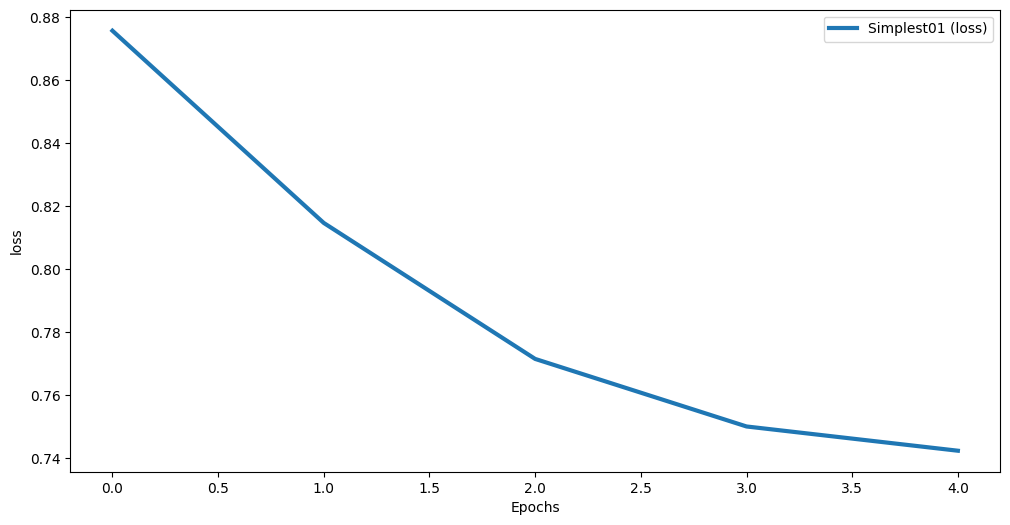

In [ ]:
plot_perf(hists,['Simplest01'],['loss'])


In [ ]:
# lets save the model
model_folder_path = os.path.join('/content/drive/MyDrive/Team CGG/Data/synth_data/models/', model_name)
os.makedirs(model_folder_path, exist_ok=True)

# Define the file path for saving the model inside the newly created folder
model_file_path = os.path.join(model_folder_path, f'{model_name}.h5')

# Save the entire model (including architecture, optimizer, and weights)
simple_autoencoder_model.save(model_file_path)

print(f'Model saved to {model_file_path}')

Model saved to /content/drive/MyDrive/Team CGG/Data/synth_data/models/Simplest01/Simplest01.h5


I haven't tried to re-load it yet but the weights should be saved and available to "pick up" with training

# Testing Model

Lets first run our data generator on test data

In [ ]:
clean_batch_test, noisy_batch_test = next(test_generator)
print(clean_batch_test.shape)


4
(384, 64, 64)


In [ ]:
from tensorflow.keras.models import load_model

# Create a separate test data generator for evaluation
test_evaluation_generator = data_generator(folder_path_test, h, w, batch_size, full_train=False)

# Make predictions using the test generator
predictions = simple_autoencoder_model.predict(test_generator, steps=4)

# Evaluate the model on the test evaluation generator
test_loss = simple_autoencoder_model.evaluate(test_evaluation_generator, steps=1)

print("Predictions shape:", predictions.shape)
print("Test loss:", test_loss)



4/4 [==============================] - 1s 220ms/step
4
1/1 [==============================] - 0s 435ms/step - loss: 0.7404
Predictions shape: (1536, 64, 64, 1)
Test loss: 0.7404170036315918


Note- here we are judged by the loss function that we specified in the compulation - so in this case its the MSE

In [ ]:
import numpy as np

def windows2img(windows, original_shape, h, w):
    rows = original_shape[0] // h
    cols = original_shape[1] // w
    combined_image = np.vstack([np.hstack(windows[i*cols:(i+1)*cols]) for i in range(rows)])
    return combined_image





12/12 [==============================] - 0s 3ms/step


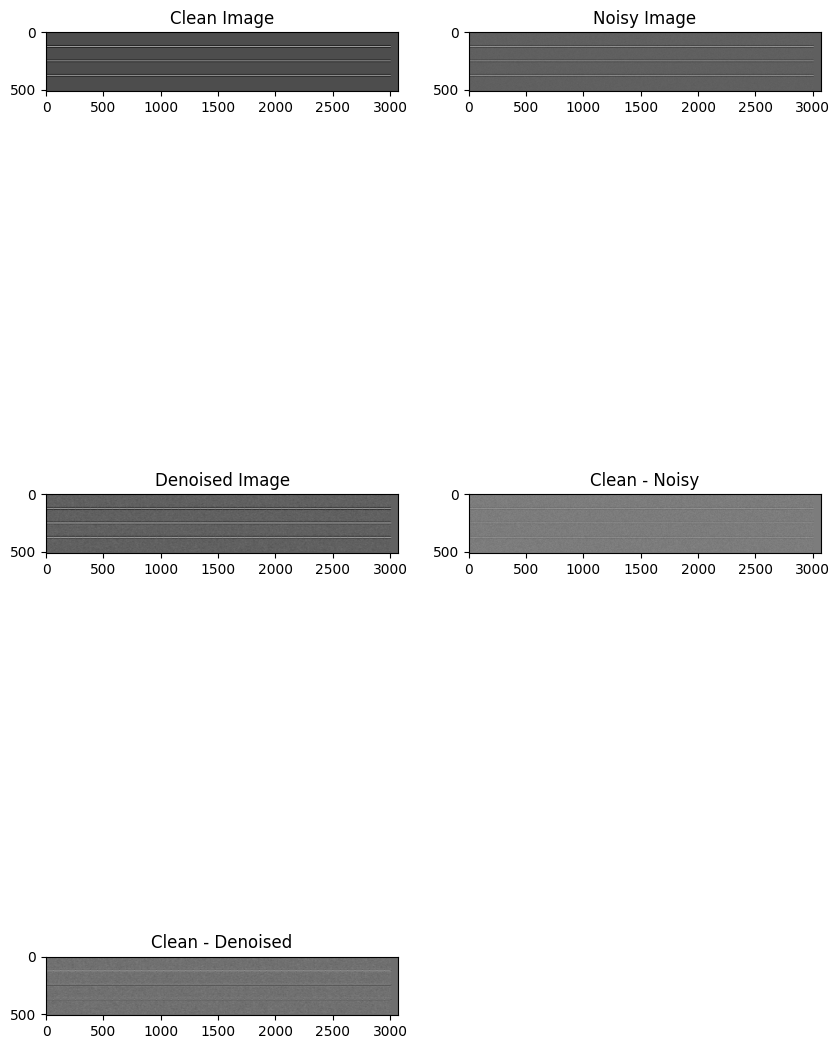

In [ ]:


def visualize_images(clean_windows, noisy_windows, denoised_windows, original_shape, h, w):
    clean_image = windows2img(clean_windows, original_shape, h, w)
    noisy_image = windows2img(noisy_windows, original_shape, h, w)
    denoised_image = windows2img(denoised_windows, original_shape, h, w)

    # Squeeze the last dimension if it has size 1
    if denoised_image.shape[-1] == 1:
        denoised_image = np.squeeze(denoised_image, axis=-1)

    clean_noisy_diff = clean_image - noisy_image
    clean_denoised_diff = clean_image - denoised_image


    fig, axs = plt.subplots(3, 2, figsize=(10, 18))

    axs[0, 0].imshow(clean_image, cmap='gray')
    axs[0, 0].set_title('Clean Image')
    axs[0, 1].imshow(noisy_image, cmap='gray')
    axs[0, 1].set_title('Noisy Image')
    axs[1, 0].imshow(denoised_image, cmap='gray')
    axs[1, 0].set_title('Denoised Image')
    axs[1, 1].imshow(clean_noisy_diff, cmap='gray')
    axs[1, 1].set_title('Clean - Noisy')
    axs[2, 0].imshow(clean_denoised_diff, cmap='gray')
    axs[2, 0].set_title('Clean - Denoised')

    for ax in axs.flat:
        ax.axis('on')

    plt.subplots_adjust( hspace=0.001)
    fig.delaxes(axs[2, 1])  # Remove the empty subplot

    plt.show()



# we get the next bit of data
clean_batch_train, noisy_batch_train = next(test_generator)

# Predict the denoised windows using the trained model
denoised_batch_test = simple_autoencoder_model.predict(noisy_batch_test)

# this is enlarged
original_shape = (512, 3072)

visualize_images(clean_batch_test, noisy_batch_test, denoised_batch_test, original_shape, h, w)




If someone knows how to make this look not awful please help me fix the plot

# Similarity metrics
this is where Emily will add her function (or maybe earlier)


We can use this sort of random metric that some use

In [ ]:
from math import log10
def PSNR(clean, noisy):
    mse = np.mean((clean - noisy) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = np.max(noisy)
    psnr = 20 * log10(max_pixel / np.sqrt(mse))
    return psnr


In [ ]:
clean_images = windows2img(clean_batch_train, original_shape, h, w)
noisy_images = windows2img(noisy_batch_train, original_shape, h, w)
denoised_images = windows2img(denoised_batch_train, original_shape, h, w)

if denoised_images.shape[-1] == 1:
  denoised_images = np.squeeze(denoised_images, axis=-1)


# Calculate PSNR between clean and noisy
psnr_clean_noisy = PSNR(clean_images, noisy_images)
print("PSNR between clean and noisy:", psnr_clean_noisy)

# Calculate PSNR between clean and denoised
psnr_clean_denoised = PSNR(clean_images, denoised_images)
print("PSNR between clean and denoised:", psnr_clean_denoised)

PSNR between clean and noisy: 22.79391965376655
PSNR between clean and denoised: 1.5398975459098367


Nice we at least have verification that its doing something!